In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")


                        load
Datetime                    
2004-12-31 01:00:00  13478.0
2004-12-31 02:00:00  12865.0
2004-12-31 03:00:00  12577.0
2004-12-31 04:00:00  12517.0
2004-12-31 05:00:00  12670.0
...                      ...
2018-01-01 20:00:00  21089.0
2018-01-01 21:00:00  20999.0
2018-01-01 22:00:00  20820.0
2018-01-01 23:00:00  20415.0
2018-01-02 00:00:00  19993.0

[121273 rows x 1 columns]


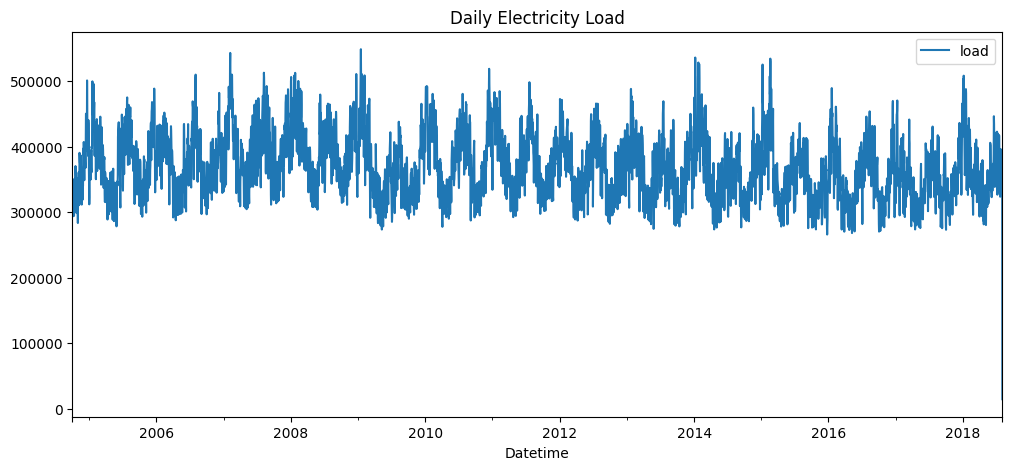

In [ ]:
# Loading the dataset
data = pd.read_csv("AEP_hourly.csv", parse_dates=['Datetime'], index_col='Datetime')

# Renaming the relevant column to 'load' for convenience
data = data.rename(columns={"AEP_MW": "load"})
print(data)
# Resampling to daily data if needed
data = data.resample('D').sum()
data.plot(figsize=(12, 5), title="Daily Electricity Load")
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['load'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")  #series is already stationary


ADF Statistic: -7.279596355145729
p-value: 1.5125837189548453e-10


In [ ]:
arima_model = ARIMA(data['load'], order=(5, 1, 5))
arima_result = arima_model.fit()
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                   load   No. Observations:                 5055
Model:                 ARIMA(5, 1, 5)   Log Likelihood              -57191.363
Date:                Sun, 10 Nov 2024   AIC                         114404.726
Time:                        02:49:55   BIC                         114476.534
Sample:                    10-01-2004   HQIC                        114429.880
                         - 08-03-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1802      0.020     -8.938      0.000      -0.220      -0.141
ar.L2         -0.6598      0.016    -41.116      0.000      -0.691      -0.628
ar.L3         -0.6072      0.029    -21.068      0.0

In [ ]:
sarima_model = SARIMAX(data['load'], order=(5, 1, 5), seasonal_order=(1, 1, 1, 7))
sarima_result = sarima_model.fit()
print(sarima_result.summary())


                                      SARIMAX Results                                      
Dep. Variable:                                load   No. Observations:                 5055
Model:             SARIMAX(5, 1, 5)x(1, 1, [1], 7)   Log Likelihood              -56979.617
Date:                             Sun, 10 Nov 2024   AIC                         113985.234
Time:                                     02:50:43   BIC                         114070.080
Sample:                                 10-01-2004   HQIC                        114014.957
                                      - 08-03-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2176     14.588      0.015      0.988     -28.374      28.809
ar.L2         -0.0108     1

In [ ]:
from sklearn.metrics import mean_absolute_error

arima_pred = arima_result.predict(start=1, end=len(data))
sarima_pred = sarima_result.predict(start=1, end=len(data))

arima_pred = arima_pred[:len(data['load'][1:])]
sarima_pred = sarima_pred[:len(data['load'][1:])]

# Calculating R-squared for ARIMA and SARIMA
arima_r2 = r2_score(data['load'][1:], arima_pred)
sarima_r2 = r2_score(data['load'][1:], sarima_pred)

print(f"ARIMA R^2 Score: {arima_r2}")
print(f"SARIMA R^2 Score: {sarima_r2}")


ARIMA R^2 Score: 0.8278375975014091
SARIMA R^2 Score: 0.8547821080469696


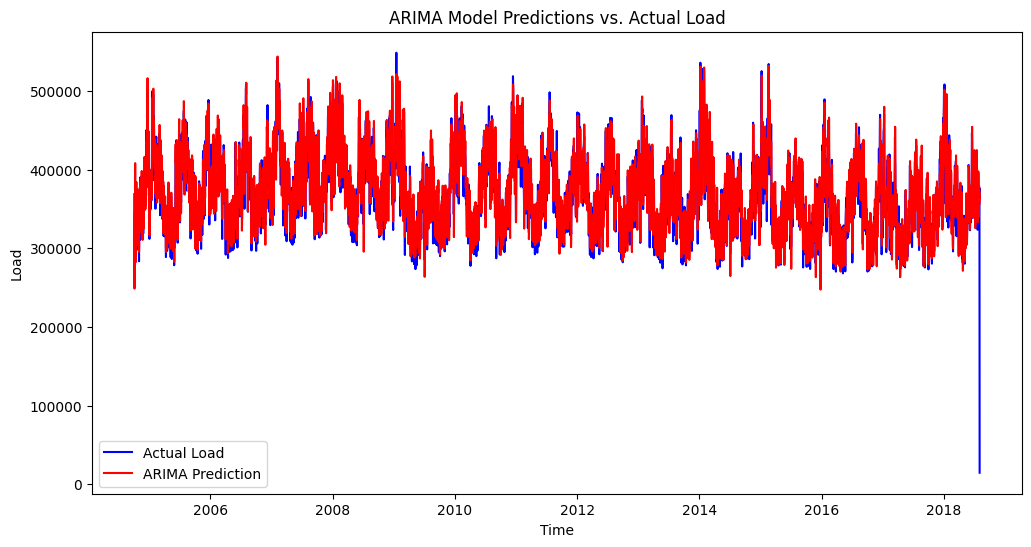

In [ ]:
import matplotlib.pyplot as plt

# Adjusing predictions to match the length of actual values
arima_pred = arima_pred[:len(data['load'][1:])]
sarima_pred = sarima_pred[:len(data['load'][1:])]

# Plot ARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(data['load'][1:], label="Actual Load", color="blue")
plt.plot(data.index[1:], arima_pred, label="ARIMA Prediction", color="red")
plt.title("ARIMA Model Predictions vs. Actual Load")
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.show()





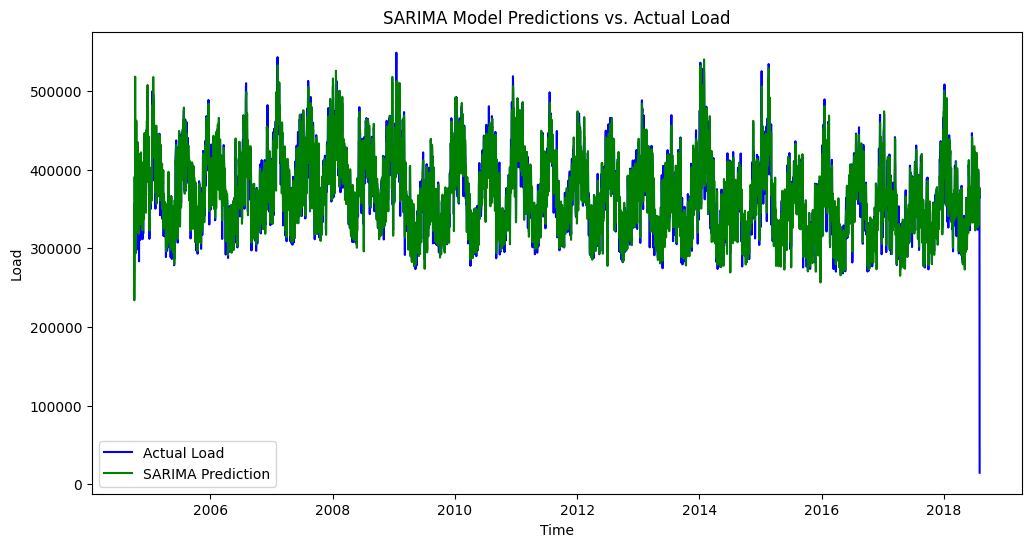

In [ ]:
# Plot SARIMA predictions
plt.figure(figsize=(12, 6))
plt.plot(data['load'][1:], label="Actual Load", color="blue")
plt.plot(data.index[1:], sarima_pred, label="SARIMA Prediction", color="green")
plt.title("SARIMA Model Predictions vs. Actual Load")
plt.xlabel("Time")
plt.ylabel("Load")
plt.legend()
plt.show()

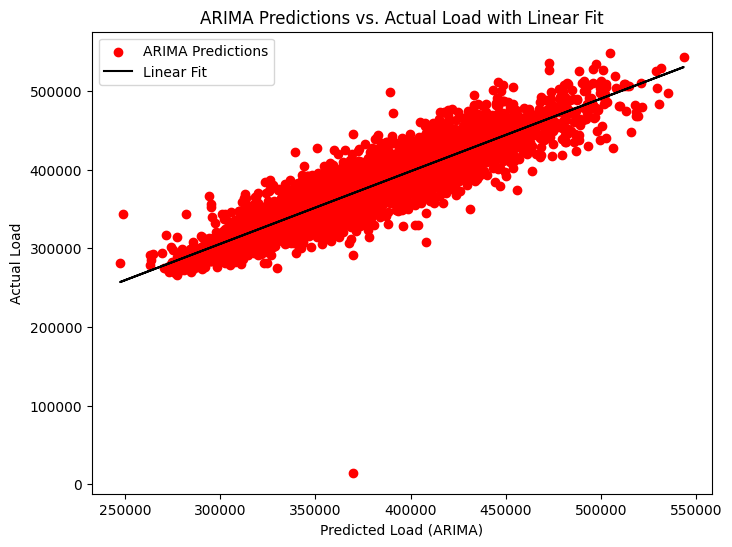

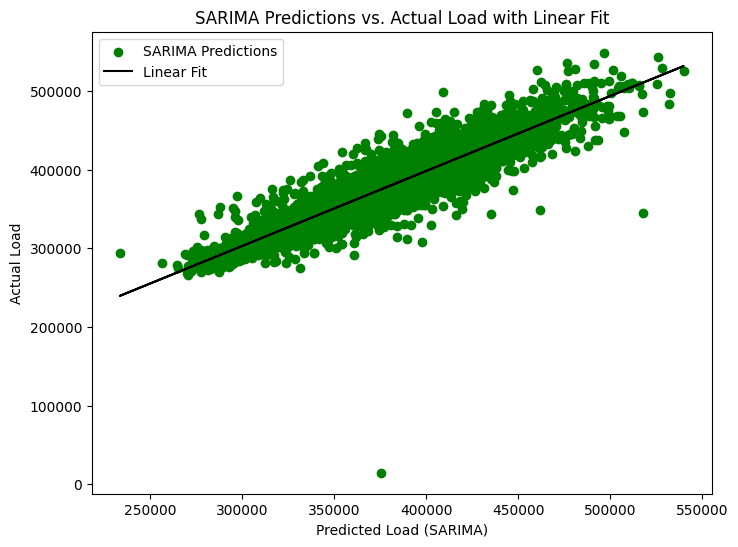

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Reshape data for linear regression
actual_values = data['load'][1:].values.reshape(-1, 1)
arima_pred = np.array(arima_pred).reshape(-1, 1)
sarima_pred = np.array(sarima_pred).reshape(-1, 1)

# Linear regression for ARIMA predictions
lr_arima = LinearRegression().fit(arima_pred, actual_values)
arima_line = lr_arima.predict(arima_pred)

plt.figure(figsize=(8, 6))
plt.scatter(arima_pred, actual_values, color="red", label="ARIMA Predictions")
plt.plot(arima_pred, arima_line, color="black", label="Linear Fit")
plt.xlabel("Predicted Load (ARIMA)")
plt.ylabel("Actual Load")
plt.title("ARIMA Predictions vs. Actual Load with Linear Fit")
plt.legend()
plt.show()

# Linear regression for SARIMA predictions
lr_sarima = LinearRegression().fit(sarima_pred, actual_values)
sarima_line = lr_sarima.predict(sarima_pred)

plt.figure(figsize=(8, 6))
plt.scatter(sarima_pred, actual_values, color="green", label="SARIMA Predictions")
plt.plot(sarima_pred, sarima_line, color="black", label="Linear Fit")
plt.xlabel("Predicted Load (SARIMA)")
plt.ylabel("Actual Load")
plt.title("SARIMA Predictions vs. Actual Load with Linear Fit")
plt.legend()
plt.show()


In [ ]:
# Reshape predictions to fit Linear Regression
actual_values = data['load'][1:].values.reshape(-1, 1)
arima_pred = np.array(arima_pred).reshape(-1, 1)
sarima_pred = np.array(sarima_pred).reshape(-1, 1)

# Linear regression and R^2 score for ARIMA
lr_arima = LinearRegression().fit(arima_pred, actual_values)
arima_lr_score = lr_arima.score(arima_pred, actual_values)

# Linear regression and R^2 score for SARIMA
lr_sarima = LinearRegression().fit(sarima_pred, actual_values)
sarima_lr_score = lr_sarima.score(sarima_pred, actual_values)

print(f"ARIMA Linear Regression R^2 Score: {arima_lr_score}")
print(f"SARIMA Linear Regression R^2 Score: {sarima_lr_score}")


ARIMA Linear Regression R^2 Score: 0.8337346165217403
SARIMA Linear Regression R^2 Score: 0.857028483328523


In [ ]:
##Prophet
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv("AEP_hourly.csv")
data = data[['Datetime', 'AEP_MW']].copy()
data.columns = ['ds', 'y']  # Rename columns as required by Prophet

# Check the first few rows
print(data.head())

                    ds        y
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0


In [ ]:
model = Prophet()
model.fit(data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp20gvx29_/ov9xakwl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp20gvx29_/v4lsbf6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57736', 'data', 'file=/tmp/tmp20gvx29_/ov9xakwl.json', 'init=/tmp/tmp20gvx29_/v4lsbf6c.json', 'output', 'file=/tmp/tmp20gvx29_/prophet_modelrw2gndng/prophet_model-20241110032331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:26:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


C:\Users\Siddharth\OneDrive\Documents\New folder\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Siddharth\OneDrive\Documents\New folder\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:04:07 - cmdstanpy - INFO - Chain [1] done processing


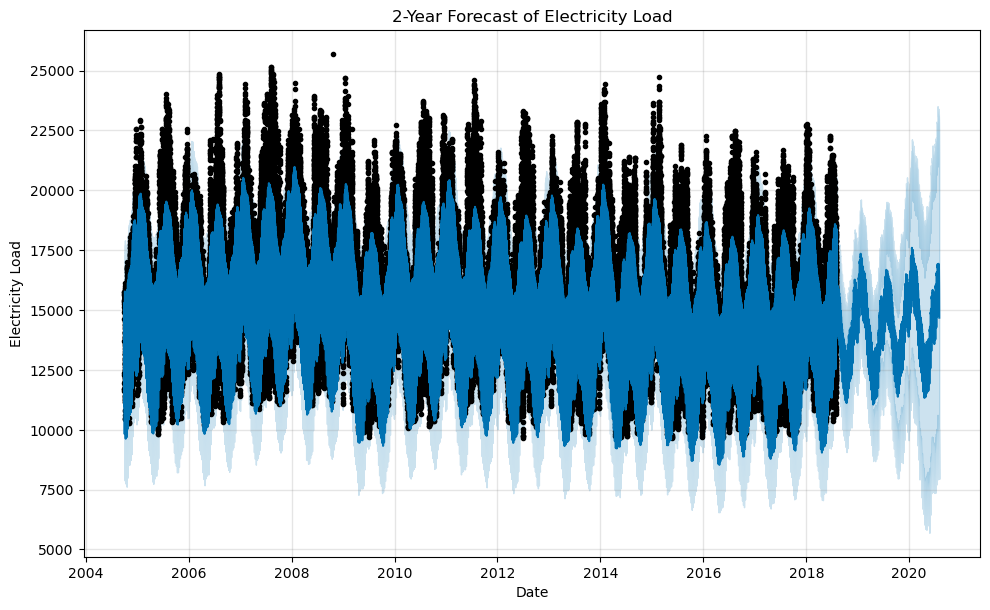

In [1]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset and preprocess for Prophet
data = pd.read_csv("AEP_hourly.csv")
data = data[['Datetime', 'AEP_MW']].copy()
data.columns = ['ds', 'y']  # Rename columns as required by Prophet

# Initialize and fit the Prophet model
model = Prophet()
model.fit(data)

# Create a future dataframe for the next 730 days (2 years)
future = model.make_future_dataframe(periods=730)  # periods=730 for 2 years of daily data

# Generate the forecast
forecast = model.predict(future)

# Plot the forecasted values
fig1 = model.plot(forecast)
plt.title("2-Year Forecast of Electricity Load")
plt.xlabel("Date")
plt.ylabel("Electricity Load")
plt.show()